In [ ]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import image_dataset_from_directory
import sklearn
from sklearn.metrics import classification_report
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [70]:
dataset_path="../../Dataset/dataset_blood_group"
BATCH_SIZE = 32

In [71]:
dataset=image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(64, 64),
    batch_size=BATCH_SIZE,
    shuffle=True
)

class_names=dataset.class_names


def convert_to_grayScale_and_normalize(image, label):
    image=tf.image.rgb_to_grayscale(image)
    image=tf.cast(image, tf.float32) /255.0
    return image, label

dataset = dataset.map(convert_to_grayScale_and_normalize)

Found 6000 files belonging to 8 classes.


# Exploratory Data Analysis

In [72]:
class_counts=Counter()
for _, labels in dataset.unbatch():
    class_counts[int(labels.numpy())]+=1
print('Class Distribution')
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count}")

Class Distribution
B-: 741
B+: 652
O-: 712
AB+: 708
AB-: 761
A-: 1009
A+: 565
O+: 852


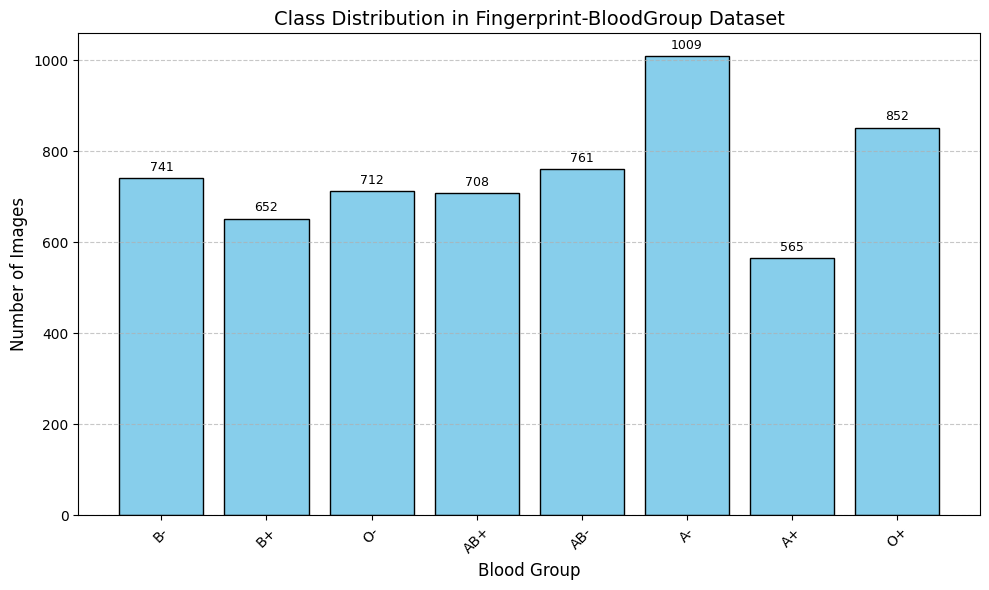

In [73]:
def plot_class_distribution(class_names, class_counts):
    classes=[class_names[i] for i in class_counts.keys()]
    counts=[class_counts[i] for i in class_counts.keys()]
    plt.figure(figsize=(10, 6))
    bars=plt.bar(classes, counts, color='skyblue', edgecolor='black')
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), 
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

    plt.title("Class Distribution in Fingerprint-BloodGroup Dataset", fontsize=14)
    plt.xlabel("Blood Group", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()
plot_class_distribution(class_names, class_counts)

# Resampling

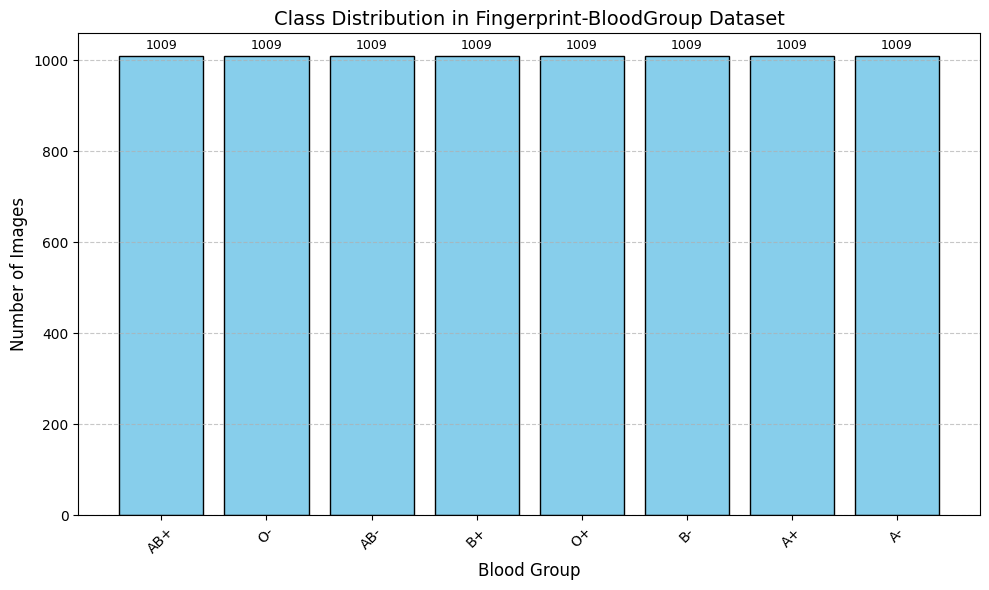

In [74]:
max_count=max(class_counts.values())
def oversample_class(class_id, count, max_count):
    unbatched_dataset=dataset.unbatch()
    class_dataset=unbatched_dataset.filter(lambda img, lbl: tf.equal(lbl, class_id))
    repeat_factor=max_count // count + (max_count%count>0)
    return class_dataset.repeat(repeat_factor).take(max_count)

balanced_datasets = []
for class_id, count in class_counts.items():
    balanced_datasets.append(oversample_class(class_id, count, max_count))

balanced_dataset=tf.data.Dataset.sample_from_datasets(balanced_datasets)
balanced_class_counts=Counter([int(lbl.numpy()) for _, lbl in balanced_dataset])
balanced_dataset = balanced_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
plot_class_distribution(class_names, balanced_class_counts)

In [75]:
balanced_dataset_unbatched=balanced_dataset.unbatch()
X, y = [], []
for img, label in balanced_dataset_unbatched:
    X.append(img.numpy())
    y.append(label.numpy())

X = np.array(X)
y = np.array(y)

np.savez_compressed("processed_data.npz", X=X, y=y)

dataset_size=sum(1 for _ in balanced_dataset_unbatched)
train_ratio=0.8
val_ratio=0.1

train_size=int(train_ratio*dataset_size)
val_size=int(val_ratio*dataset_size)

train_dataset=balanced_dataset_unbatched.take(train_size)
val_test_dataset=balanced_dataset_unbatched.skip(train_size)
val_dataset=val_test_dataset.take(val_size)
test_dataset=val_test_dataset.skip(val_size)
train_dataset = train_dataset.shuffle(buffer_size=1000)


train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

train_batch_count = sum(1 for _ in train_dataset)
val_batch_count = sum(1 for _ in val_dataset)
test_batch_count = sum(1 for _ in test_dataset)

print(f"Training dataset size: {train_batch_count * BATCH_SIZE}")
print(f"Val dataset size: {val_batch_count * BATCH_SIZE}")
print(f"Training dataset size: {test_batch_count * BATCH_SIZE}")
# for sample in balanced_dataset.take(2):
#     print(sample[0].shape)

Training dataset size: 6432
Val dataset size: 800
Training dataset size: 800


# Deep Learning Model

In [76]:
def create_high_accuracy_model():
    model=keras.models.Sequential([

        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 1)),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Dropout(0.3),

        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Dropout(0.3),


        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Dropout(0.3),


        keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Dropout(0.3),


        keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Dropout(0.3),


        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(0.3),


        keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [77]:
model=create_high_accuracy_model()
high_acc = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50
)

Epoch 1/50


c:\Users\thuni\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    201/Unknown 52s 212ms/step - accuracy: 0.1965 - loss: 1.9875

c:\Users\thuni\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


201/201 ━━━━━━━━━━━━━━━━━━━━ 75s 327ms/step - accuracy: 0.1970 - loss: 1.9862 - val_accuracy: 0.3413 - val_loss: 1.6542
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 71s 320ms/step - accuracy: 0.6694 - loss: 0.8761 - val_accuracy: 0.6731 - val_loss: 0.7990
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 78s 348ms/step - accuracy: 0.7856 - loss: 0.5422 - val_accuracy: 0.8293 - val_loss: 0.3933
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 81s 367ms/step - accuracy: 0.8137 - loss: 0.4868 - val_accuracy: 0.8377 - val_loss: 0.3999
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 93s 423ms/step - accuracy: 0.8334 - loss: 0.4245 - val_accuracy: 0.8546 - val_loss: 0.3230
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 77s 346ms/step - accuracy: 0.8524 - loss: 0.3934 - val_accuracy: 0.8510 - val_loss: 0.2931
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 77s 348ms/step - accuracy: 0.8531 - loss: 0.3864 - val_accuracy: 0.8185 - val_loss: 0.3661
Epoch 8/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 78s 350ms/step - accuracy: 0.8602 - loss: 0.3567 - val

# Model Evaluation

In [78]:
acc_eval=model.evaluate(val_dataset)
print(f"Accuracy is {acc_eval}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9685 - loss: 0.0908
Accuracy is [0.08347265422344208, 0.9350961446762085]


In [79]:
y_true=[]
y_predicted=[]
for images, labels in test_dataset:
    predictions=model.predict(images)
    predicted_labels=np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_predicted.extend(predicted_labels)
    print(f"Actual: {labels[0]}, {labels[1]}\t Predicted {predicted_labels[0]}, {predicted_labels[1]}")

y_true=np.array(y_true)
y_predicted=np.array(y_predicted)
report=classification_report(y_true, y_predicted, target_names=class_names)
print(f"Classification report :/n {report}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
Actual: 0, 5	 Predicted 0, 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Actual: 3, 7	 Predicted 3, 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Actual: 4, 0	 Predicted 4, 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Actual: 0, 7	 Predicted 0, 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Actual: 5, 1	 Predicted 5, 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Actual: 1, 2	 Predicted 1, 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Actual: 4, 3	 Predicted 4, 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Actual: 1, 5	 Predicted 1, 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Actual: 2, 7	 Predicted 2, 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Actual: 4, 2	 Predicted 4, 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Actual: 6, 6	 Predicted 6, 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Actual: 3, 6	 Predicted 3, 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Actual: 7, 2	 Predicted 7, 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Actual: 7, 0	 Predicted 7, 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Actual: 6, 4	 Predicted

# Prdeictions

In [97]:
model.save("../../model/model.h5")

In [96]:
def predict_single_image(img_path):
    img=keras.preprocessing.image.load_img(img_path, target_size=(64, 64))
    img=tf.image.rgb_to_grayscale(img)
    img_array=keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array=np.expand_dims(img_array, axis=0)
    predicted=model.predict(img_array)
    predicted_blood_group=np.argmax(predicted, axis=1)[0]
    confidence = np.max(predicted)
    print(f"Predicted: {class_names[predicted_blood_group]} (Confidence: {confidence:.2f})")
    print(img_array.shape)
    print(class_names)

predict_single_image("../../Dataset/dataset_blood_group/O-/cluster_7_65.BMP")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Predicted: O- (Confidence: 1.00)
(1, 64, 64, 1)
['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']
